## Perceived Labor Income Risks and Asset Returns


- This notebook first downloads asset return indicators 
- Then we examine the correlation of higher moments of labor income risks and asset returns 
- It also inspects the cross-sectional pattern of the subjective moments

In [1]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import statsmodels.api as sm 
import scipy.stats as st  
from statsmodels.graphics import tsaplots as tsplt

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

###  1. Download stock return series 

In [3]:
## s&p 500 series 

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2019, 10, 30)

In [4]:
## downloading the data from Fred
sp500D= web.DataReader('sp500', 'fred', start, end)
vixD = web.DataReader('VIXCLS','fred',start,end)

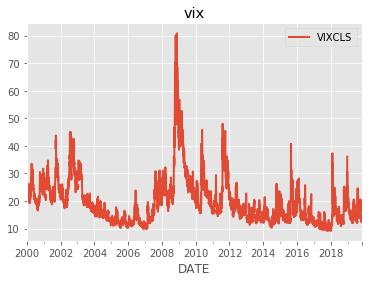

In [5]:
vixD.plot(lw=2)
vixplt = plt.title('vix')

In [6]:
#plotting
#sp500D.plot(lw=2)
#sp500plt = plt.title('S&P 500')

In [7]:
## collapse to monthly data 
sp500D.index = pd.to_datetime(sp500D.index)
sp500M = sp500D.resample('M').last()

vixD.index = pd.to_datetime(vixD.index)
vixM = vixD.resample('M').mean()

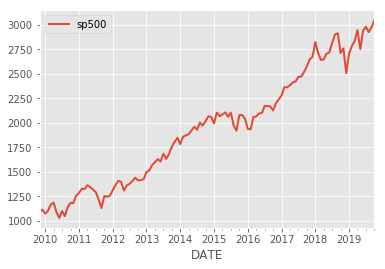

In [8]:
sp500M.plot(lw=2)
#sp500Mplt = plt.title('S&P 500 (end of month)')

In [9]:
sp500MR = np.log(sp500M).diff()

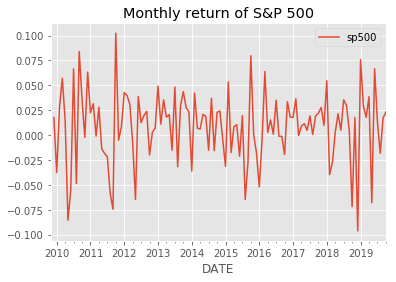

In [10]:
sp500MR.plot()
sp500MRplt = plt.title('Monthly return of S&P 500')

###  2. Loading and cleaning perceived income series 

In [11]:
## loading the stata file
SCEProbIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEProbIndM.dta')
SCEDstIndM = pd.read_stata('../SurveyData/SCE/IncExpSCEDstIndM.dta')

In [12]:
## subselect the dataframe
sub_var = ['date',
           'userid',
           'Q24_var',
           'Q24_mean',
           'Q24_iqr',
           'Q24_rmean',
           'Q24_rvar']
IncSCEIndMoms = SCEProbIndM[sub_var]
sub_var2 = ['date','userid','IncVar','IncMean','IncSkew','IncKurt']
IncSCEIndMomsEst = SCEDstIndM[sub_var2]

## drop nan observations
IncSCEIndMoms = IncSCEIndMoms.dropna(how='any')
IncSCEIndMomsEst = IncSCEIndMomsEst.dropna(how='any')

In [13]:
## deal with clusterring skewness value around zero first

#IncSCEIndMomsEst['IncSkew'] = IncSCEIndMomsEst['IncSkew'].copy().replace(0,np.nan)

In [14]:
moms = ['Q24_mean','Q24_var','Q24_iqr','Q24_rmean','Q24_rvar']
moms_est = ['IncVar','IncMean','IncSkew','IncKurt']

## compute population summary stats for these ind moms
IncSCEPopMomsMed = pd.pivot_table(data = IncSCEIndMoms, 
                                  index=['date'], 
                                  values = moms,
                                  aggfunc= 'median').reset_index().rename(columns={'Q24_mean': 'meanMed', 
                                                                                   'Q24_var': 'varMed',
                                                                                  'Q24_iqr': 'iqrMed',
                                                                                   'Q24_rmean':'rmeanMed',
                                                                                   'Q24_rvar':'rvarMed'})

IncSCEPopMomsMean = pd.pivot_table(data = IncSCEIndMoms, 
                                   index=['date'], 
                                  values = moms,
                                  aggfunc= 'mean').reset_index().rename(columns={'Q24_mean': 'meanMean',
                                                                                 'Q24_var': 'varMean',
                                                                                 'Q24_iqr': 'iqrMean',
                                                                                 'Q24_rmean':'rmeanMean',
                                                                                 'Q24_rvar':'rvarMean'})

IncSCEPopMomsEstMed = pd.pivot_table(data = IncSCEIndMomsEst, 
                                     index=['date'],
                                     values = moms_est,
                                     aggfunc= 'median').reset_index().rename(columns={'IncMean': 'meanEstMed',
                                                                                      'IncVar': 'varEstMed',
                                                                                      'IncSkew': 'skewEstMed',
                                                                                      'IncKurt':'kurtEstMed'})

IncSCEPopMomsEstMean = pd.pivot_table(data = IncSCEIndMomsEst, 
                                      index=['date'],
                                      values = moms_est,
                                      aggfunc= 'mean').reset_index().rename(columns={'IncMean': 'meanEstMean',
                                                                                    'IncVar': 'varEstMean',
                                                                                    'IncSkew': 'skewEstMean',
                                                                                    'IncKurt':'kurtEstMean'})

In [15]:
T = len(IncSCEPopMomsEstMean)

### 3. Cross-sectional patterns of subjective distributions


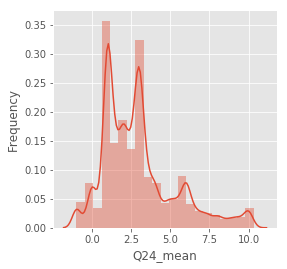

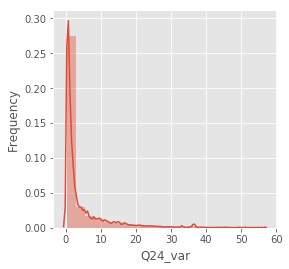

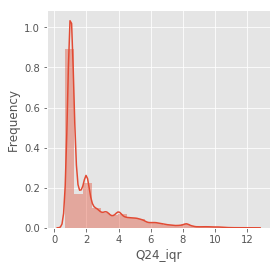

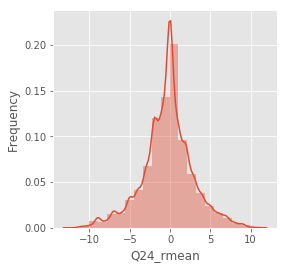

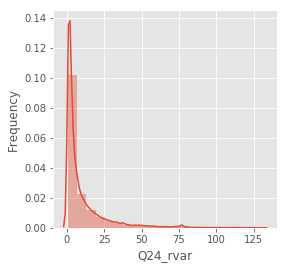

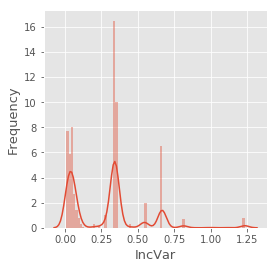

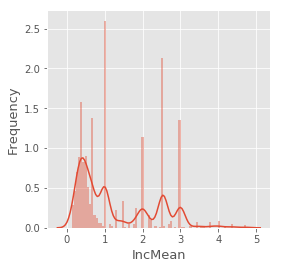

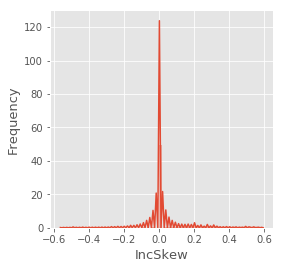

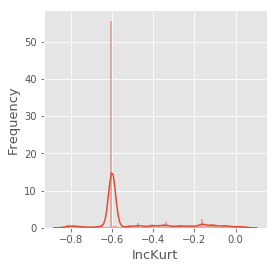

In [16]:
### histograms 

for mom in moms:
    fig,ax = plt.subplots(figsize=(4,4))
    sns.distplot(IncSCEIndMoms[mom],
                 kde = True,
                 bins = 21) 
    plt.xlabel(mom, fontsize = 12)
    plt.xlabel(mom,fontsize = 12)
    plt.ylabel("Frequency",fontsize = 12)
    plt.savefig('../Graphs/ind/hist_'+str(mom)+'.jpg')
    
for mom in moms_est:
    fig,ax = plt.subplots(figsize=(4,4))
    mom_nonan = IncSCEIndMomsEst[mom].dropna()
    mom_lb, mom_ub = np.percentile(mom_nonan,6),np.percentile(mom_nonan,94) ## exclude top and bottom 3% observations
    #print(mom_lb)
    #print(mom_ub)
    to_keep = (mom_nonan < mom_ub) & (mom_nonan > mom_lb)
    #print(to_keep.shape)
    mom_nonan_truc = mom_nonan[to_keep]
    #print(mom_nonan_truc.shape)
    sns.distplot(mom_nonan_truc,
                 kde = True, 
                 bins = 80) 
    plt.xlabel(mom, fontsize = 13)
    plt.ylabel("Frequency",fontsize = 13)
    plt.savefig('../Graphs/ind/hist'+str(mom)+'.jpg')

### 4. Combinine the two series 

In [17]:
## streamline the dates for merging 

# adjusting the end-of-month dates to the begining-of-month for combining 
sp500MR.index = sp500MR.index.shift(1,freq='D') 
vixM.index = vixM.index.shift(1,freq='D')


IncSCEPopMomsMed.index = pd.DatetimeIndex(IncSCEPopMomsMed['date'] ,freq='infer')
IncSCEPopMomsMean.index = pd.DatetimeIndex(IncSCEPopMomsMean['date'] ,freq='infer')
IncSCEPopMomsEstMed.index = pd.DatetimeIndex(IncSCEPopMomsEstMed['date'] ,freq='infer')
IncSCEPopMomsEstMean.index = pd.DatetimeIndex(IncSCEPopMomsEstMean['date'] ,freq='infer')

In [18]:
dt_combM = pd.concat([sp500MR,
                      vixM,
                      IncSCEPopMomsMed,
                      IncSCEPopMomsMean,
                      IncSCEPopMomsEstMed,
                      IncSCEPopMomsEstMean],
                     join="inner",
                     axis=1).drop(columns=['date'])

In [19]:
dt_combM.tail()

,sp500,VIXCLS,iqrMed,meanMed,rmeanMed,rvarMed,varMed,iqrMean,meanMean,rmeanMean,rvarMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
2018-01-01,0.01,10.26,1.34,2.75,0.00,3.48,0.96,2.17,2.99,-0.11,10.00,3.76,-0.60,1.00,0.00,0.33,-0.45,1.88,0.04,0.49
2018-02-01,0.05,11.06,1.27,2.85,0.00,3.69,0.87,2.26,3.09,-0.18,10.52,4.22,-0.60,1.00,0.00,0.33,-0.51,1.84,0.05,0.48
2018-03-01,-0.04,22.46,1.17,2.62,-0.00,3.39,0.67,2.16,2.93,-0.35,10.39,3.94,-0.60,1.00,0.00,0.33,-0.51,1.92,0.05,0.49
2018-04-01,-0.03,19.02,1.19,2.86,0.00,3.93,0.77,2.08,3.06,-0.15,9.81,3.44,-0.60,1.00,0.00,0.33,-0.46,1.81,0.07,0.46
2018-05-01,0.00,18.27,1.19,2.79,-0.05,3.81,0.78,2.20,3.01,-0.29,10.81,3.86,-0.60,1.00,0.00,0.33,-0.47,1.74,0.06,0.45


In [20]:
## date index for panel 

IncSCEIndMoms.index = IncSCEIndMoms['date']
IncSCEIndMoms.index.name = None
IncSCEIndMomsEst.index = IncSCEIndMomsEst['date']
IncSCEIndMomsEst.index.name = None

In [21]:
## merge individual moments and macro series 

dt_combIndMs = pd.merge(IncSCEIndMoms,
                        IncSCEIndMomsEst,
                        on = ['date','userid'])
dt_combIndMs.index = dt_combIndMs['date']

dt_combMacroM = pd.merge(sp500MR,
                         vixM,
                         left_index = True,
                         right_index = True)

dt_combIndM = pd.merge(dt_combMacroM,
                       dt_combIndMs,
                       left_index = True,
                       right_index = True)

### 5. Seasonal adjustment (not successful yet)

In [22]:
to_sa_test = ['meanMed']
to_sa_list = list(dt_combM.columns.drop('sp500'))

/Users/Myworld/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:476: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]


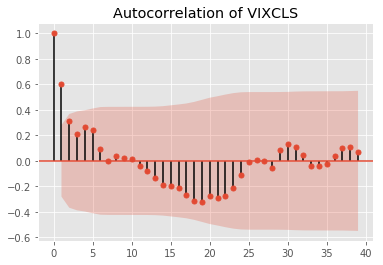

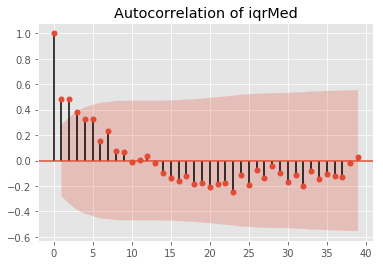

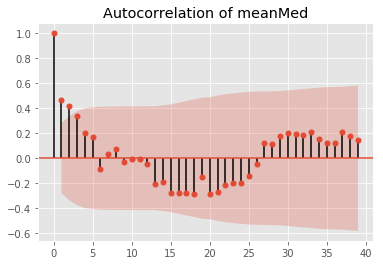

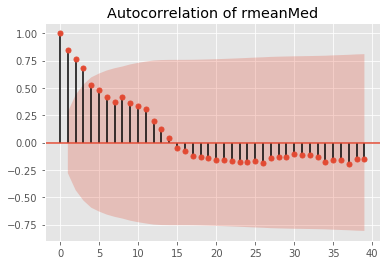

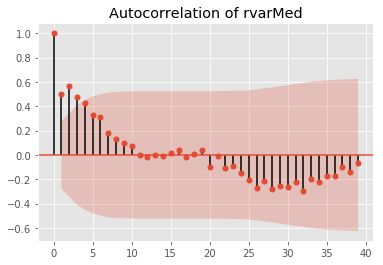

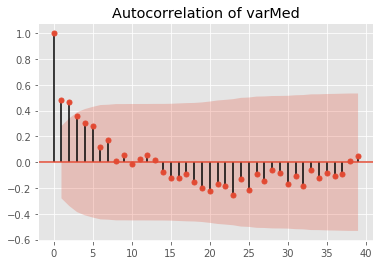

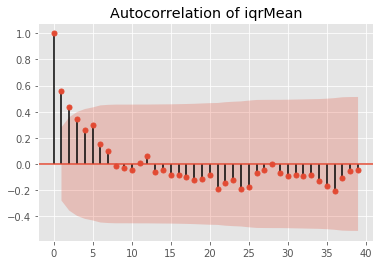

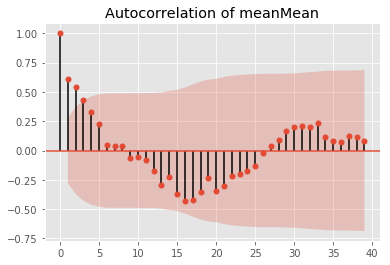

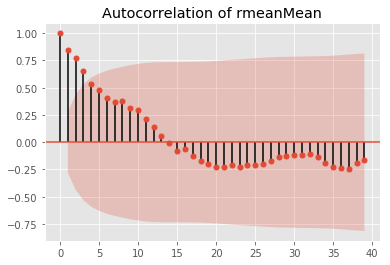

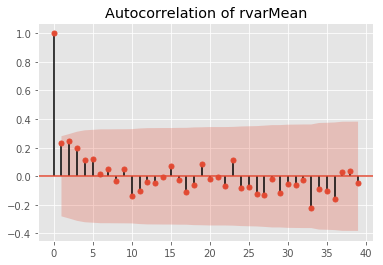

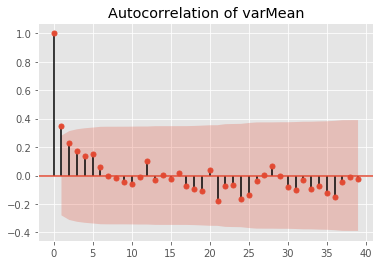

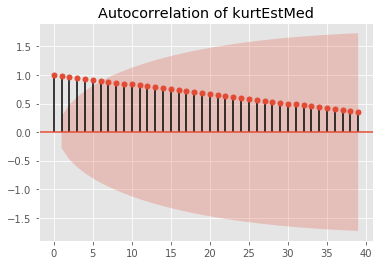

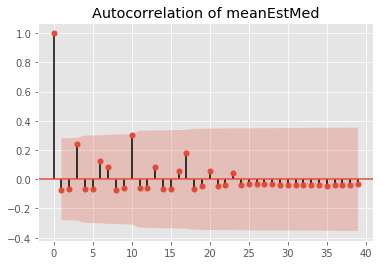

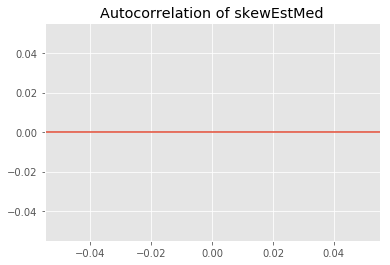

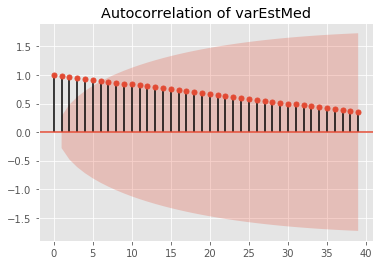

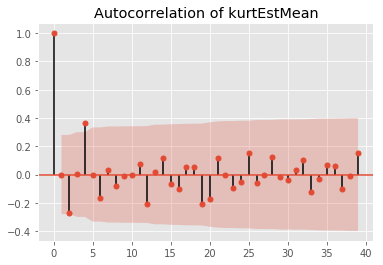

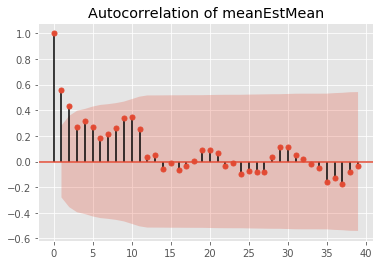

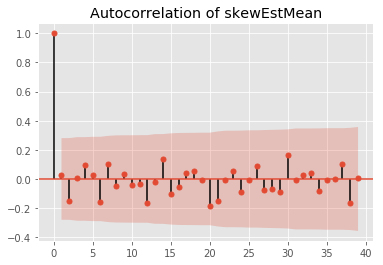

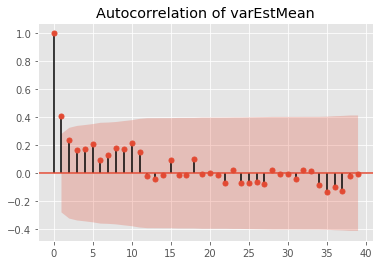

In [23]:
## inspect for seasonal pattern by looking into the autocovariance

for sr in to_sa_list:
    tsplt.plot_acf(dt_combM[sr],
                   lags = np.arange(T-20),
                   alpha = 0.03)
    plt.title('Autocorrelation of '+ sr)
    plt.savefig('../Graphs/pop/acf_'+str(sr)+'.jpg')

- Judging from the acf plots, it seems that only the population mean and median of expected earning growth has seasonal patterns at 12 month frequency, higher moments such as variance, skewness does not have this pattern.   

In [24]:
for sr in to_sa_test:
    series = dt_combM[sr]
    samodel = sm.tsa.UnobservedComponents(series,
                                          level='fixed intercept',
                                          seasonal = 12)
    res = samodel.fit(disp = True)
    print(res.summary())
    #res_plt = res.plot_components(figsize=(4,11))
    #plt.plot(res.level.filtered)

                            Unobserved Components Results                            
Dep. Variable:                       meanMed   No. Observations:                   60
Model:                       fixed intercept   Log Likelihood                 -72.426
                   + stochastic seasonal(12)   AIC                            146.853
Date:                       Mon, 25 Nov 2019   BIC                            148.724
Time:                               11:07:29   HQIC                           147.560
Sample:                           06-01-2013                                         
                                - 05-01-2018                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal     1.1039      0.288      3.838      0.00

### 6. Correlation with stock market returns and times series patterns 

In [25]:
corr_table = dt_combM.corr()
corr_table.to_excel('../Tables/corrM.xlsx')
corr_table

,sp500,VIXCLS,iqrMed,meanMed,rmeanMed,rvarMed,varMed,iqrMean,meanMean,rmeanMean,rvarMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,-0.45,0.04,0.06,-0.04,0.00,0.03,0.15,0.03,-0.07,0.10,0.17,-0.00,0.01,nan,0.00,-0.00,-0.13,-0.02,-0.12
VIXCLS,-0.45,1.00,0.02,0.05,0.17,0.11,0.03,-0.05,-0.02,0.11,0.11,-0.04,-0.00,0.01,nan,-0.00,0.11,-0.09,0.06,-0.10
iqrMed,0.04,0.02,1.00,0.56,0.16,0.67,0.99,0.77,0.67,0.25,0.47,0.61,0.00,-0.14,nan,0.00,-0.11,0.07,0.22,-0.14
meanMed,0.06,0.05,0.56,1.00,0.54,0.29,0.59,0.51,0.87,0.51,0.32,0.42,-0.00,0.02,nan,-0.00,-0.21,0.42,0.23,0.21
rmeanMed,-0.04,0.17,0.16,0.54,1.00,-0.06,0.17,0.05,0.50,0.92,-0.02,0.04,-0.00,0.06,nan,0.00,-0.07,0.54,0.11,0.31
rvarMed,0.00,0.11,0.67,0.29,-0.06,1.00,0.68,0.68,0.43,0.01,0.65,0.54,-0.00,-0.15,nan,0.00,0.08,-0.21,0.13,-0.30
varMed,0.03,0.03,0.99,0.59,0.17,0.68,1.00,0.77,0.68,0.27,0.45,0.61,0.00,-0.15,nan,0.00,-0.12,0.07,0.23,-0.14
iqrMean,0.15,-0.05,0.77,0.51,0.05,0.68,0.77,1.00,0.64,0.13,0.69,0.95,0.00,-0.20,nan,0.00,-0.18,-0.05,0.15,-0.16
meanMean,0.03,-0.02,0.67,0.87,0.50,0.43,0.68,0.64,1.00,0.56,0.37,0.50,0.00,-0.01,nan,0.00,-0.23,0.38,0.27,0.17
rmeanMean,-0.07,0.11,0.25,0.51,0.92,0.01,0.27,0.13,0.56,1.00,-0.05,0.09,-0.00,0.08,nan,0.00,-0.06,0.46,0.14,0.22


In [26]:
## try different lags or leads

lead_loop = 6

def pval_str(pval):
    if pval < 0.01:
        star = '***'
    elif pval >= 0.01 and pval<0.05:
        star = '**'
    elif pval >= 0.05 and pval <= 0.1:
        star = '*'
    else:
        star = ''
    return star

def corrtostr(corr): 
    return str(round(corr[0],2)) + str(pval_str(corr[1]))

def corrprint(corr,
              var):
    print('correlation coefficient betwen sp500 and median'+
              str(var) + 
              ' is ' + 
              str(round(corr[0],2)) +
              ', and p-value is ' + 
              str(round(corr[1],2))
             )

corr_list = []
col_list = []

#print('median')
for moms in ['var','iqr','rvar']:
    col_list.append('median:'+str(moms))
    for lead in range(lead_loop):
        corr = st.pearsonr(np.array(dt_combM['sp500'][lead+1:]),
                           np.array(dt_combM[str(moms)+'Med'])[:-(lead+1)]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr, moms)

for moms in ['skew']:
    col_list.append('mean:'+str(moms))
    for lead in range(lead_loop):
        corr = st.pearsonr(np.array(dt_combM['sp500'][lead+1:]),
                           np.array(dt_combM[str(moms)+'EstMed'])[:-(lead+1)]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr,moms)
        
#print('mean')

for moms in ['var','iqr','rvar']:
    col_list.append('mean:'+str(moms))
    for lead in range(lead_loop):
        corr = st.pearsonr(np.array(dt_combM['sp500'][lead+1:]),
                           np.array(dt_combM[str(moms)+'Mean'])[:-(lead+1)]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr,moms)
        
for moms in ['skew']:
    col_list.append('mean:'+str(moms))
    for lead in range(lead_loop):
        corr = st.pearsonr(np.array(dt_combM['sp500'][lead+1:]),
                           np.array(dt_combM[str(moms)+'EstMean'])[:-(lead+1)]
                          )
        corr_str = corrtostr(corr)
        corr_list.append(corr_str)
        #corrprint(corr,moms)
        
             
corr_array = np.array(corr_list).reshape([int(len(corr_list)/lead_loop),
                                          lead_loop])
corr_df = pd.DataFrame(corr_array,
                       index = col_list)

/Users/Myworld/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [27]:
corr_df

,0,1,2,3,4,5
median:var,-0.08,-0.14,-0.33**,-0.17,-0.08,-0.15
median:iqr,-0.1,-0.13,-0.33**,-0.15,-0.08,-0.19
median:rvar,-0.07,-0.01,-0.17,-0.09,-0.13,-0.33**
mean:skew,nan,nan,nan,nan,nan,nan
mean:var,-0.03,-0.09,-0.24*,-0.08,-0.13,-0.2
mean:iqr,-0.05,-0.07,-0.29**,-0.16,-0.12,-0.18
mean:rvar,-0.09,-0.01,-0.08,-0.12,-0.12,-0.23*
mean:skew,-0.07,-0.12,-0.0,-0.27**,0.24*,-0.02


In [28]:
## output tables 

beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}
\\begin{table}"""

endtex = "\end{table}\end{document}"


to_drop = ['Intercept']


## write to latex 

f = open('../Tables/latex/macro_corr.tex', 'w')
f.write(beginningtex)
tb_ltx = corr_df.to_latex()
f.write(tb_ltx)
f.write(endtex)
f.close()

Correlation coefficient is 0.061, p-value is 0.646
Correlation coefficient is 0.033, p-value is 0.805
Correlation coefficient is 0.043, p-value is 0.747
Correlation coefficient is -0.037, p-value is 0.777
Correlation coefficient is 0.004, p-value is 0.976
Correlation coefficient is 0.013, p-value is 0.921
Correlation coefficient is 0.0, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is 0.0, p-value is 1.0


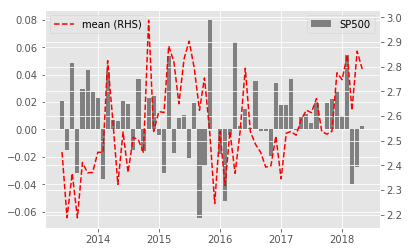

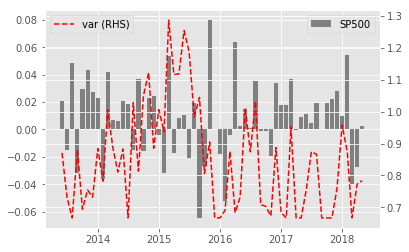

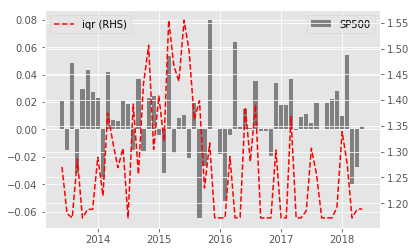

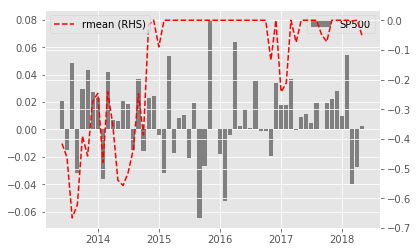

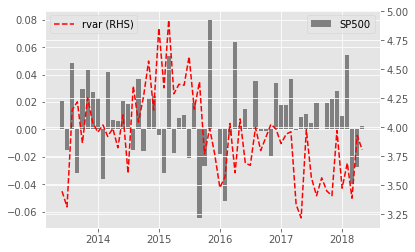

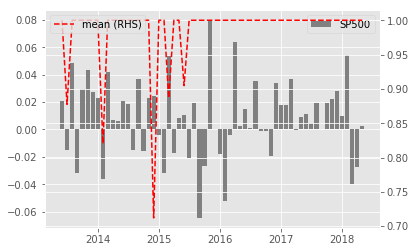

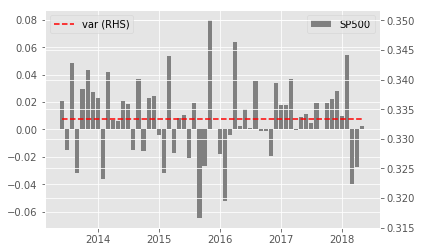

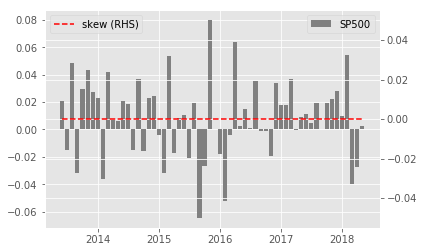

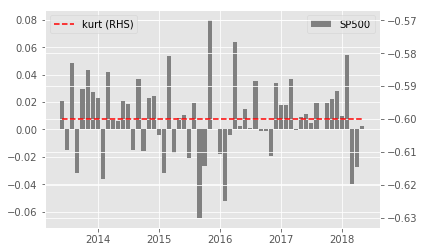

In [29]:
## plots of correlation for MEDIAN population stats 

for i,moms in enumerate( ['mean','var','iqr','rmean','rvar']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsMed'+str(moms)+'.jpg')
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'Med']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))
    

for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsEstMed'+str(moms)+'.jpg')
    cor,pval = st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'EstMed']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))

Correlation coefficient is 0.031, p-value is 0.813
Correlation coefficient is 0.169, p-value is 0.196
Correlation coefficient is 0.146, p-value is 0.267
Correlation coefficient is -0.068, p-value is 0.606
Correlation coefficient is 0.097, p-value is 0.461
Correlation coefficient is -0.127, p-value is 0.333
Correlation coefficient is -0.118, p-value is 0.368
Correlation coefficient is -0.022, p-value is 0.867
Correlation coefficient is -0.001, p-value is 0.995


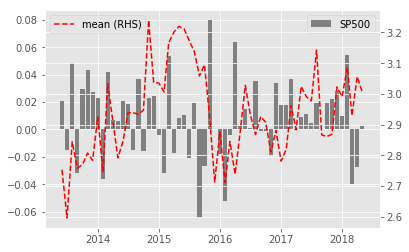

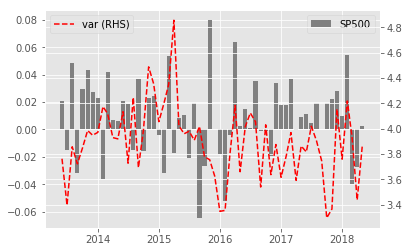

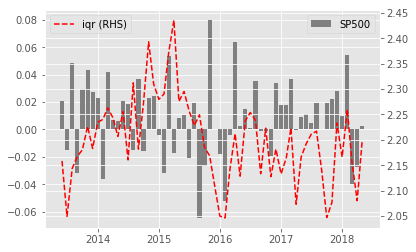

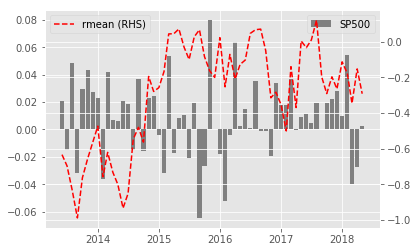

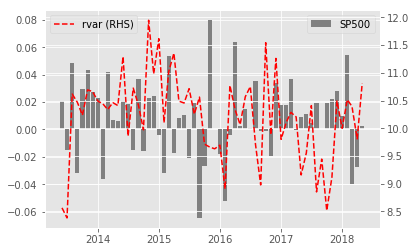

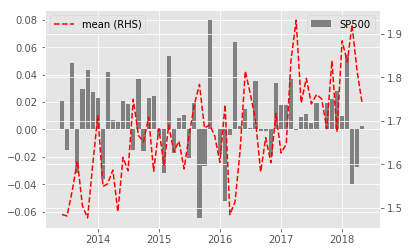

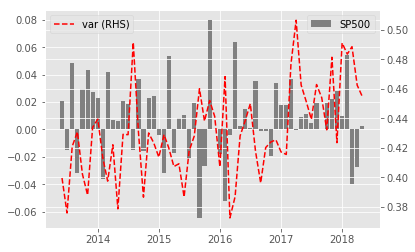

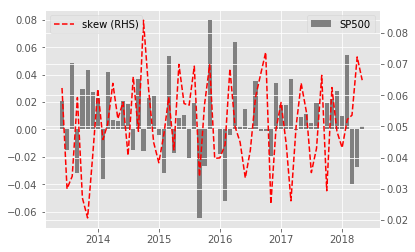

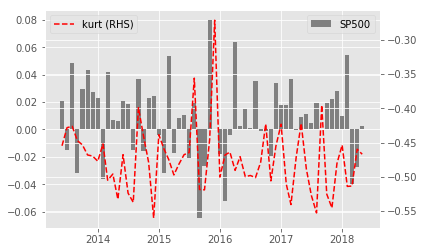

In [30]:
## plots of correlation for Mean population stats 

for i,moms in enumerate( ['mean','var','iqr','rmean','rvar']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsMean'+str(moms)+'.jpg')
    
    cor,pval = st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'Mean']))
    print('Correlation coefficient is '+str(round(cor,3)) + ', p-value is '+ str(round(pval,3)))
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM.index, dt_combM['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsEstMean'+str(moms)+'.jpg')
    cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
                          np.array(dt_combM[str(moms)+'EstMean']))
    print('Correlation coefficient is '+str(round(cor,3) ) + ', p-value is '+ str(round(pval,3) ))

In [31]:
## moving average 

dt_combM3mv = dt_combM.rolling(3).mean()

In [32]:
crr3mv_table = dt_combM3mv.corr()
crr3mv_table.to_excel('../Tables/corr3mvM.xlsx')
crr3mv_table

,sp500,VIXCLS,iqrMed,meanMed,rmeanMed,rvarMed,varMed,iqrMean,meanMean,rmeanMean,rvarMean,varMean,kurtEstMed,meanEstMed,skewEstMed,varEstMed,kurtEstMean,meanEstMean,skewEstMean,varEstMean
sp500,1.00,-0.55,-0.16,-0.21,-0.24,-0.13,-0.18,0.02,-0.24,-0.28,0.01,0.09,0.00,0.09,nan,nan,-0.18,-0.13,-0.32,-0.07
VIXCLS,-0.55,1.00,0.10,0.01,0.18,0.24,0.11,-0.03,-0.05,0.14,0.17,-0.02,-0.00,-0.10,nan,nan,0.37,-0.22,0.12,-0.24
iqrMed,-0.16,0.10,1.00,0.65,0.15,0.80,0.99,0.88,0.80,0.25,0.61,0.78,-0.00,-0.48,nan,nan,-0.04,-0.07,0.41,-0.31
meanMed,-0.21,0.01,0.65,1.00,0.59,0.29,0.67,0.55,0.91,0.56,0.27,0.51,-0.00,-0.21,nan,nan,-0.28,0.55,0.43,0.30
rmeanMed,-0.24,0.18,0.15,0.59,1.00,-0.10,0.16,0.00,0.50,0.96,-0.15,-0.01,0.00,0.09,nan,nan,-0.06,0.61,0.22,0.35
rvarMed,-0.13,0.24,0.80,0.29,-0.10,1.00,0.80,0.81,0.49,-0.03,0.79,0.72,0.00,-0.55,nan,nan,0.16,-0.41,0.20,-0.54
varMed,-0.18,0.11,0.99,0.67,0.16,0.80,1.00,0.88,0.81,0.27,0.61,0.79,0.00,-0.47,nan,nan,-0.04,-0.07,0.39,-0.31
iqrMean,0.02,-0.03,0.88,0.55,0.00,0.81,0.88,1.00,0.71,0.08,0.78,0.97,0.00,-0.55,nan,nan,-0.22,-0.13,0.30,-0.31
meanMean,-0.24,-0.05,0.80,0.91,0.50,0.49,0.81,0.71,1.00,0.56,0.37,0.63,0.00,-0.30,nan,nan,-0.20,0.42,0.46,0.16
rmeanMean,-0.28,0.14,0.25,0.56,0.96,-0.03,0.27,0.08,0.56,1.00,-0.17,0.04,-0.00,0.10,nan,nan,-0.02,0.54,0.24,0.26


Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0
Correlation coefficient is nan, p-value is 1.0


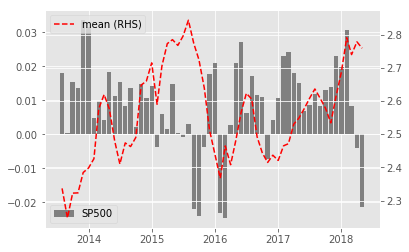

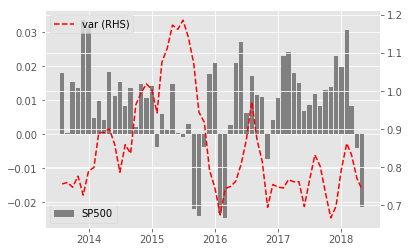

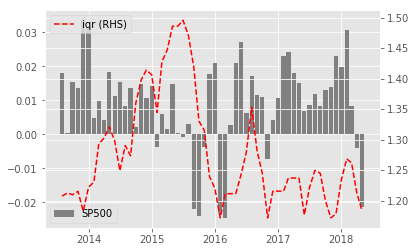

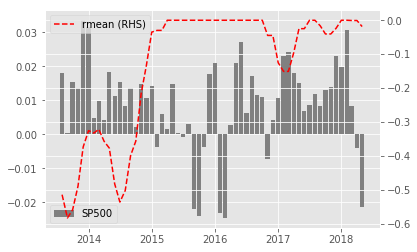

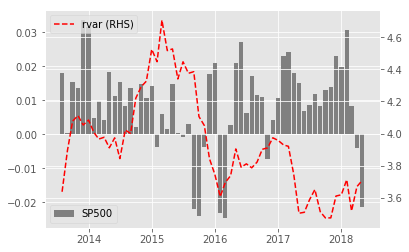

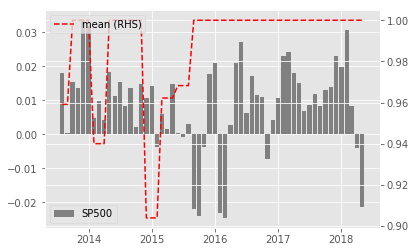

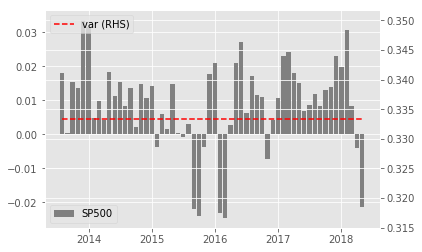

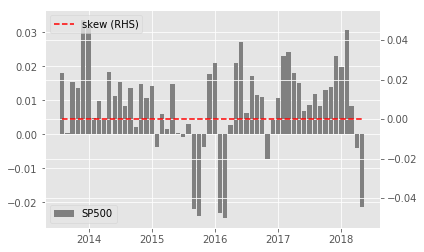

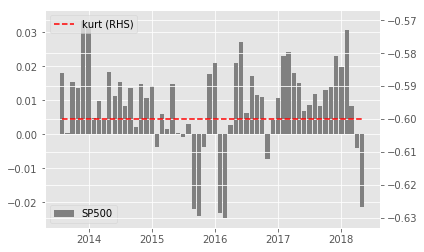

In [33]:
## plots of correlation for 3-month moving MEDIAN average 

for i,moms in enumerate( ['mean','var','iqr','rmean','rvar']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Med'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsMed3mv'+str(moms)+'.jpg')
    cor,pval = st.pearsonr(np.array(dt_combM3mv['sp500']),
                          np.array(dt_combM3mv[str(moms)+'Med']))
    print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))

for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMed'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsEstMed3mv'+str(moms)+'.jpg')
    cor,pval =st.pearsonr(np.array(dt_combM3mv['sp500']),
                          np.array(dt_combM3mv[str(moms)+'EstMed']))
    print('Correlation coefficient is '+str(round(cor,3) ) + ', p-value is '+ str(round(pval,3) ))

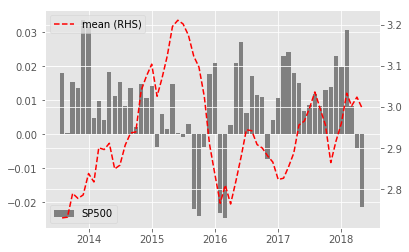

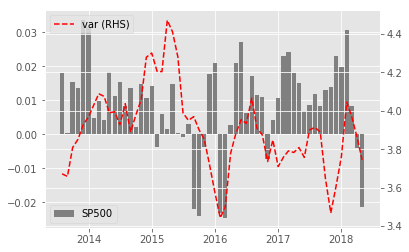

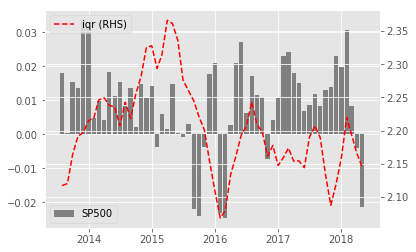

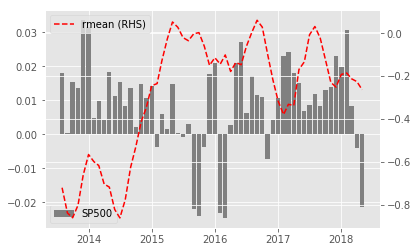

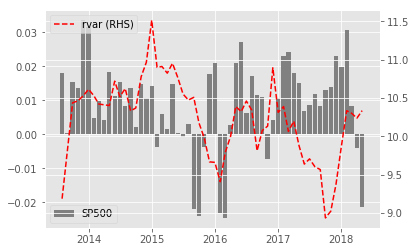

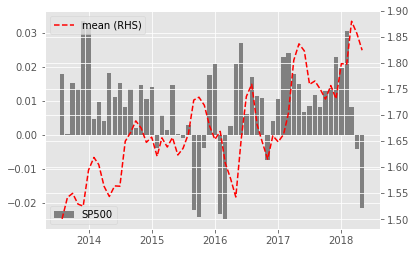

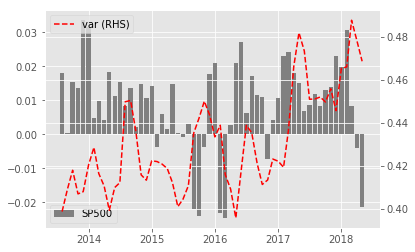

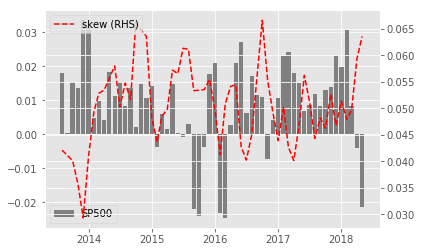

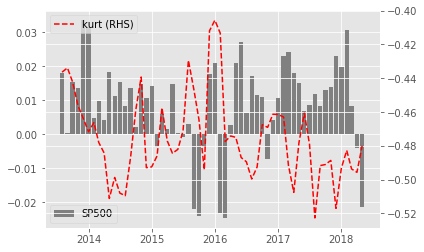

In [34]:
## plots of correlation for 3-month moving mean average 

for i,moms in enumerate( ['mean','var','iqr','rmean','rvar']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'Mean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsMean3mv'+str(moms)+'.jpg')
    #cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
    #                      np.array(dt_combM3mv[str(moms)+'Mean']))
    #print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))
    
    
for i,moms in enumerate( ['mean','var','skew','kurt']):
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.bar(dt_combM3mv.index, dt_combM3mv['sp500'], color='gray', width=25,label='SP500')
    ax2.plot(dt_combM3mv[str(moms)+'EstMean'], 'r--',label=str(moms)+' (RHS)')
    #ax.set_xticklabels(dt_combM.index)
    ax.legend(loc=0)
    ax2.legend(loc=2)
    plt.savefig('../Graphs/pop/tsEstMean3mv'+str(moms)+'.jpg')
    #cor,pval =st.pearsonr(np.array(dt_combM['sp500']),
    #                      np.array(dt_combM3mv[str(moms)+'EstMean']))
    #print('Correlation coefficient is '+str(cor) + ', p-value is '+ str(pval))

### 7. Individual regressions 

In [40]:
lead = 1

for i,moms in enumerate( ['var','iqr','rvar']):
    Y = np.array(dt_combIndM['Q24_'+str(moms)])[lead+1:]
    X = np.array(dt_combIndM['sp500'])[:-(lead+1)]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    rs = model.fit()
    print(rs.summary())
    
    
for i,moms in enumerate( ['Skew']):
    Y = np.array(dt_combIndM['Inc'+str(moms)])[lead+1:]
    X = np.array(dt_combIndM['sp500'])[:-(lead+1)]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    rs = model.fit()
    print(rs.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.317
Date:                Mon, 25 Nov 2019   Prob (F-statistic):              0.251
Time:                        11:10:58   Log-Likelihood:            -1.3027e+05
No. Observations:               38133   AIC:                         2.605e+05
Df Residuals:                   38131   BIC:                         2.606e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8815      0.039     98.319      0.0